In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, get_total_length, merge_sublists_with_shared_items, initDataset
from utils.load import get_samples, getTopofeature
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

In [2]:


trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_attack_save/"
# normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern09-24--21-13-11/local_normal_save/"
attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern11-16--22-16-38/local_attack_save/"
normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern11-16--22-16-38/local_normal_save/"

round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))

modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(30,len(client_set_attack),len(client_set_normal))


modelname = ""
if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 64
else:
    assert 0==1


Files already downloaded and verified
rounds [32, 34, 36, 22, 24, 26, 28, 30] 8
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640


In [10]:
now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d %H:%M:%S")

corr_set = []
normal_nums = int(client_max)
attack_nums = int(client_max/5)
total_nums = normal_nums+attack_nums

for idround, r in enumerate(round_set):
    # if idround >= 1:
    #     break
    r_modelpth_set = modelpth_dict[f'{r}_normal'][0:normal_nums] + modelpth_dict[f'{r}_attack'][0:attack_nums]
    r_corr = np.zeros((total_nums, total_nums, 1))

    topofeaturelist = []
    gradientlist = []
    model, Dataloader, dataset = initDataset(modelname)
    for idx, modelp1 in enumerate(r_modelpth_set):
            gradientlist.append(getGradients(modelpth=modelp1, model=model, dataloader=Dataloader))
            # topofeaturelist.append(getTopofeature(modelpth=modelp1, model=model, dataloader=Dataloader, dataset=dataset))
            topofeaturelist.append([])

    vectors = zip(gradientlist, topofeaturelist)
    # for items in vectors:
    #     print(items)
    
    for id1, v1 in enumerate(copy.deepcopy(vectors)):
        if id1 >= total_nums:
            break
        for id2, v2 in enumerate(copy.deepcopy(vectors)):
            if id2 >= total_nums:
                break
            if id2 <= id1:
                continue
            
            
            corrlist = []

            # print(gradients1)
            acts1 = v1[0]["layer3.0.conv1.weight"]
            acts2 = v2[0]["layer3.0.conv1.weight"]
            acts1 = acts1.cpu().reshape((weightsize,-1))
            acts2 = acts2.cpu().reshape((weightsize,-1))
            # fv1 = v1[1].reshape((5,-1))
            # fv2 = v2[1].reshape((5,-1))
            # print(acts1-acts2)
            # print(fv1)
            l = linear_CKA(acts1.T, acts2.T)
            k = kernel_CKA(acts1.T, acts2.T)
            # lfv = linear_CKA(fv1, fv2)
            # kfv = linear_CKA(fv1, fv2)
            corrlist.append((l+k)/4)

            r_corr[id1][id2] = np.array(corrlist)
    
    corr_set.append(r_corr)

print(len(corr_set))
print(corr_set[0].shape)
    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Traceback (most recent call last):
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/envs/torch/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/envs/torch/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/envs/torch/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-npguthyo'


Files already downloaded and verified
8
(36, 36, 1)


In [11]:
np.savetxt("./corrset_temp.txt",np.array(corr_set).reshape(len(corr_set), -1))

# PCODE

In [12]:
def is_proper_superset(list_a, list_b):
    set_a = set(list_a)
    set_b = set(list_b)
    return set_a.issubset(set_b) and len(set_a) < len(set_b)

def find_different_elements(list_a, list_b):
    set_a = set(list_a)
    set_b = set(list_b)
    different_elements = set_a.symmetric_difference(set_b)
    return list(different_elements)

def flatten(inlist:list = None):
    # if not l or len(l) <= 1:
    #     return None
    # n = np.array(l[0]).reshape(1,-1)

    
    # for i in range(1,len(l)):
    #     print(n, np.array(l[i])[:,np.newaxis])
    #     np.concatenate((n, np.array(l[i]).reshape(1,-1)))
    # return n.ravel()
    if not inlist or len(inlist) <= 1:
        return inlist
    
    new_list = []
    for l in inlist:
        for i in range(1,len(l)):
            new_list.append((l[i-1], l[i]))

    return np.array(new_list)
        

def find_largest_gaps(arr, k):
    # 计算并存储间隔及其对应的下标
    gaps_with_indices = [(arr[i+1] - arr[i], i) for i in range(len(arr) - 1)]
    
    # 按间隔从小到大进行排序
    gaps_with_indices.sort(reverse=True)
    
    # 获取k个最大间隔的下标
    largest_k_gap_indices = [index for _, index in gaps_with_indices[:k]]
    
    # 返回排序后的下标
    return sorted(largest_k_gap_indices)

        

(36, 36)


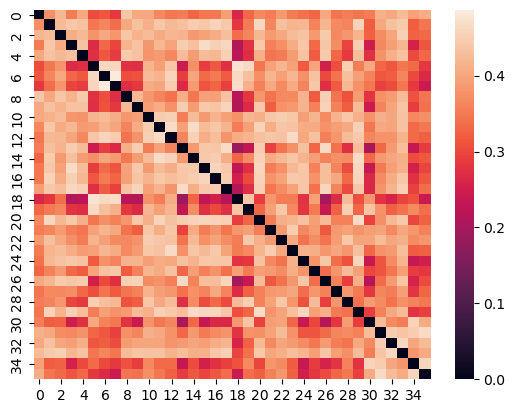

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


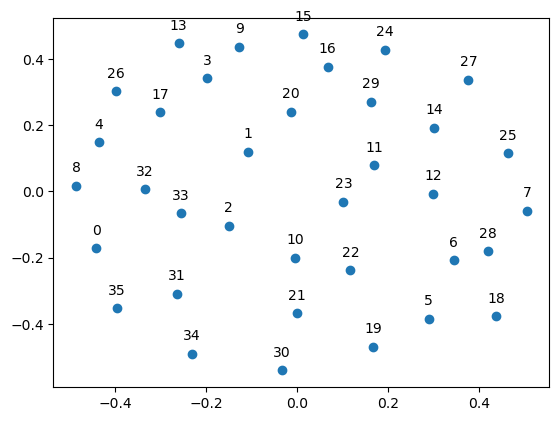

d 0 0 0.0 inf []
d 0 1 0.0 0.5840331749325554 [[10, 27]]
d 0 2 0.0 0.5610075096294788 [[0, 8]]
d 0 3 0.0 0.560498915342007 [[7, 25]]
d 0 4 0.0 0.5543690848222216 [[21, 23]]
d 0 5 0.0 0.5514955058948648 [[10, 22]]
d 0 6 0.0 0.5512945741843877 [[31, 32]]
d 0 7 0.0 0.5508259171100955 [[10, 12]]
d 0 8 0.0 0.5507079725034043 [[2, 33]]
d 0 9 0.0 0.5503957787013046 [[5, 28]]
d 0 10 0.0 0.5497823458632717 [[8, 26]]
d 0 11 0.0 0.5481080087471469 [[17, 33]]
d 0 12 0.0 0.5477717186597735 [[4, 17]]
d 0 13 0.0 0.543704915519942 [[30, 34]]
d 0 14 0.0 0.5429230493223234 [[9, 17]]
d 0 15 0.0 0.5426002678605683 [[6, 12]]
d 0 16 0.0 0.5409902887495179 [[24, 29]]
d 0 17 0.0 0.5409539253570531 [[34, 35]]
d 0 18 0.0 0.5403293856721197 [[16, 29]]
d 0 19 0.0 0.5393645812183642 [[32, 33]]
d 0 20 0.0 0.5393368755948017 [[3, 17]]
d 0 21 0.0 0.5382151935804185 [[15, 29]]
d 0 22 0.0 0.5380217389018433 [[1, 20]]
d 0 23 0.0 0.5367857775130799 [[5, 19]]
d 0 24 0.0 0.5359047347530441 [[31, 35]]
d 0 25 0.0 0.535369009

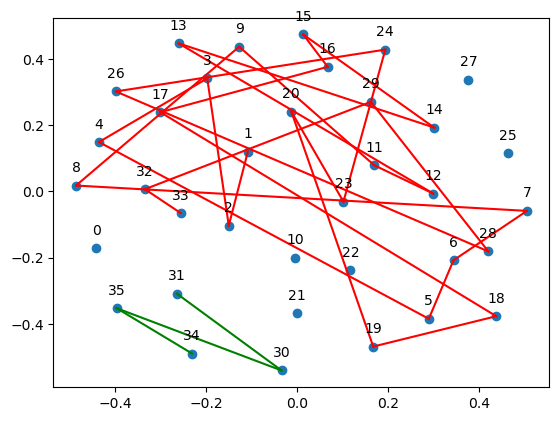

persistence =0.5512945741843877, finding: [10, 12]
 [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 26, 28, 29, 32, 33], [34, 35, 30, 31]]
merging
[[10]]
[[0, 0]]
pbow:
[array([ 2.,  8.,  6., 10.]), array([0., 2., 0., 1.])]
[[ 0.         12.52996409]
 [12.52996409  0.        ]]
score x0.5166666666666667: [0.07407407407407407] [1.0] 
total score : 0.9444444444444444

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 26, 28, 29, 32, 33], [34, 35, 30, 31]]


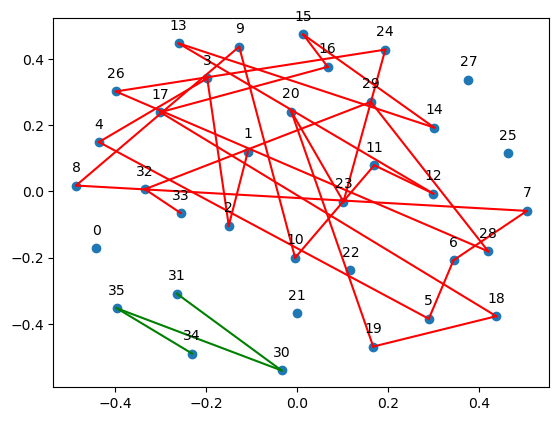

persistence =0.5514955058948648, finding: [31, 32]
 [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[30, 31, 34, 35], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 26, 28, 29, 32, 33]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  12.529964086141668 12.529964086141668
score x0.5166666666666667: [0.1935483870967742] 
total score : 0.8333333333333334

persistence =0.5543690848222216, finding: [10, 22]
 [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[22]]
[[0, 0]]
score x0.5333333333333333: [0.1875] 
total score : 0.8333333333333334

persistence =0.560498915342007, finding: [21, 23]
 [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[21]]
[[0, 0]]
score x0.55: [0.18181818181818182] 
total score : 0.8333333333333

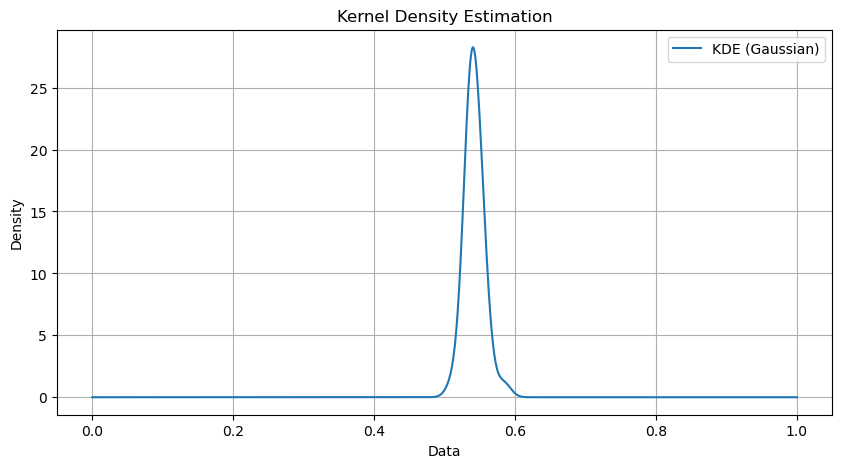

(36, 36)


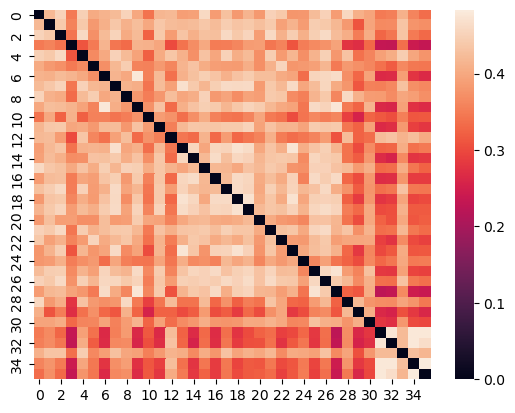

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


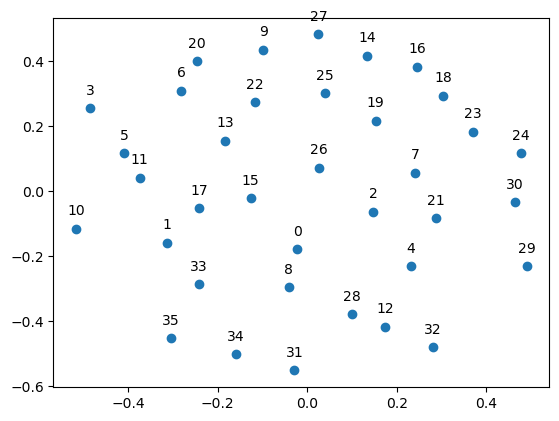

d 0 0 0.0 inf []
d 0 1 0.0 0.5892675883011227 [[3, 10]]
d 0 2 0.0 0.5848483635107986 [[3, 6]]
d 0 3 0.0 0.5816877869123165 [[17, 24]]
d 0 4 0.0 0.5795316253393 [[28, 29]]
d 0 5 0.0 0.5695542327325589 [[25, 30]]
d 0 6 0.0 0.5678840231885554 [[12, 32]]
d 0 7 0.0 0.5642051370180711 [[4, 12]]
d 0 8 0.0 0.55746579021565 [[9, 20]]
d 0 9 0.0 0.5556225647139805 [[4, 33]]
d 0 10 0.0 0.5556037043262227 [[5, 8]]
d 0 11 0.0 0.5546002280736453 [[1, 17]]
d 0 12 0.0 0.548098123294473 [[11, 19]]
d 0 13 0.0 0.5476923933500654 [[0, 2]]
d 0 14 0.0 0.5448363586876264 [[5, 22]]
d 0 15 0.0 0.54143229069084 [[0, 28]]
d 0 16 0.0 0.5397479150881608 [[0, 15]]
d 0 17 0.0 0.5396913901433869 [[2, 4]]
d 0 18 0.0 0.539576753030413 [[8, 28]]
d 0 19 0.0 0.5389567210643168 [[2, 26]]
d 0 20 0.0 0.5388060547727441 [[16, 27]]
d 0 21 0.0 0.5377800861358669 [[17, 18]]
d 0 22 0.0 0.5376291796858291 [[16, 18]]
d 0 23 0.0 0.5373651637407038 [[21, 26]]
d 0 24 0.0 0.5367727107907498 [[19, 26]]
d 0 25 0.0 0.5359406375796822 [[14,

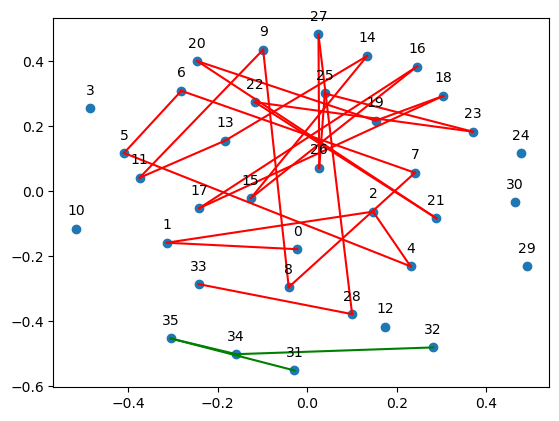

persistence =0.5678840231885554, finding: [4, 12]
 [[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 33], [32, 34, 35, 31]]
merging
[[12]]
[[0, 0]]
pbow:
[array([11.,  7.,  5.,  3.]), array([0., 3., 0., 0.])]
[[ 0.         13.07669683]
 [13.07669683  0.        ]]
score x0.5166666666666667: [0.037037037037037035] [1.0] 
total score : 0.9722222222222222

[[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 33], [32, 34, 35, 31]]


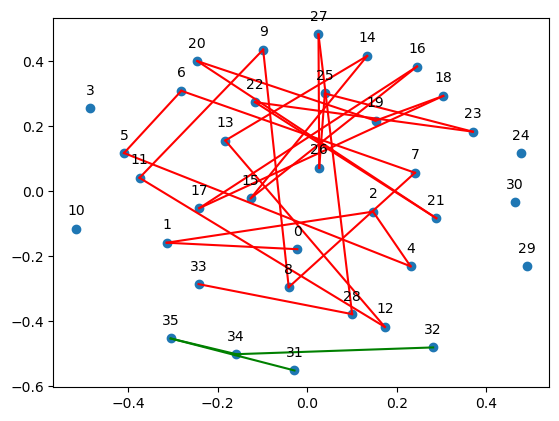

persistence =0.5695542327325589, finding: [12, 32]
 [[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 31, 32, 33, 34, 35]]
merging
[[31, 32, 34, 35], [0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 33]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  13.076696830622021 13.076696830622021
score x0.5166666666666667: [0.16129032258064516] 
total score : 0.8611111111111112

persistence =0.5795316253393, finding: [25, 30]
 [[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35]]
merging
[[30]]
[[0, 0]]
score x0.5333333333333333: [0.1875] 
total score : 0.8333333333333334

persistence =0.5816877869123165, finding: [28, 29]
 [[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[29]]
[[0, 0]]
score x0.55: [0.18181818181818182] 
total score : 0.83333333333333

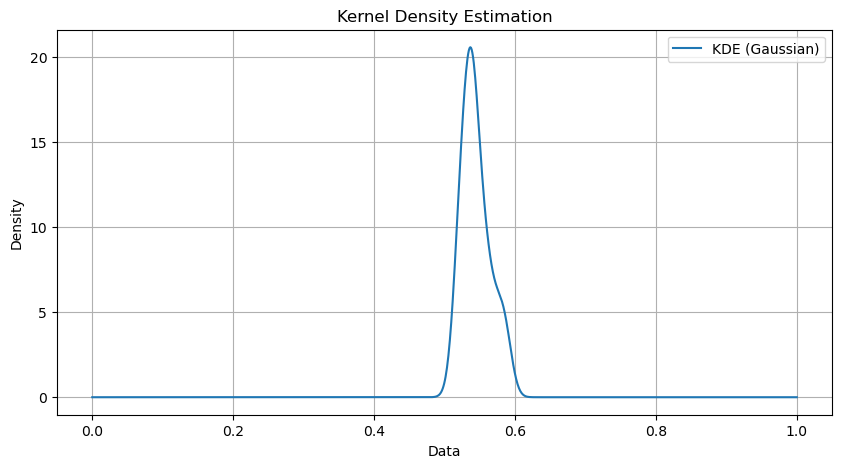

(36, 36)


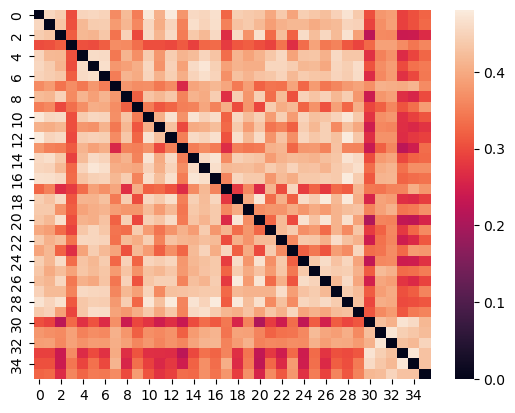

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


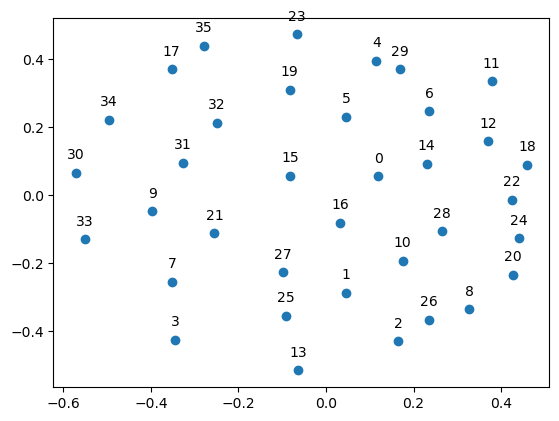

d 0 0 0.0 inf []
d 0 1 0.0 0.6085738491585336 [[3, 25]]
d 0 2 0.0 0.5847886629655716 [[7, 16]]
d 0 3 0.0 0.5802341508007558 [[25, 31]]
d 0 4 0.0 0.5709018118597528 [[13, 27]]
d 0 5 0.0 0.5609043612188882 [[16, 19]]
d 0 6 0.0 0.5592595788910835 [[9, 21]]
d 0 7 0.0 0.5551902717058624 [[31, 33]]
d 0 8 0.0 0.5531606976622774 [[11, 26]]
d 0 9 0.0 0.5518650303323485 [[2, 8]]
d 0 10 0.0 0.5511017840020103 [[25, 26]]
d 0 11 0.0 0.5485690781174943 [[32, 35]]
d 0 12 0.0 0.5470289445710609 [[5, 21]]
d 0 13 0.0 0.5463813022013605 [[17, 23]]
d 0 14 0.0 0.5460226895220945 [[23, 29]]
d 0 15 0.0 0.5431994028590592 [[4, 27]]
d 0 16 0.0 0.5396395587888031 [[4, 5]]
d 0 17 0.0 0.537140300348514 [[22, 27]]
d 0 18 0.0 0.5359257300931715 [[15, 16]]
d 0 19 0.0 0.5348793250959298 [[6, 15]]
d 0 20 0.0 0.5346570384420648 [[15, 29]]
d 0 21 0.0 0.534411327325039 [[1, 14]]
d 0 22 0.0 0.5317992084908141 [[2, 28]]
d 0 23 0.0 0.5312937173918022 [[20, 24]]
d 0 24 0.0 0.5293538852648145 [[30, 33]]
d 0 25 0.0 0.527697271

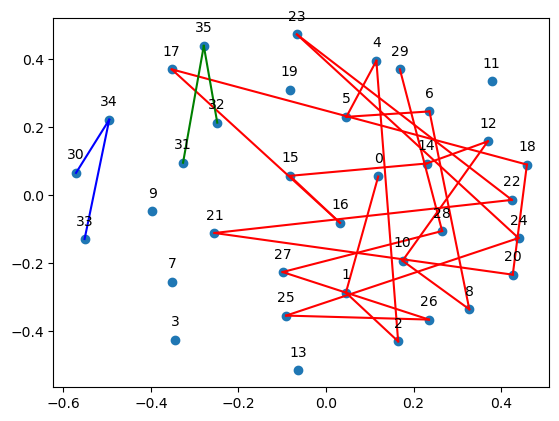

persistence =0.5551902717058624, finding: [11, 26]
 [[0, 1, 2, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [32, 35, 31], [33, 34, 30]]
merging
[[11]]
[[0, 0]]
pbow:
[array([9., 8., 7.]), array([1., 0., 1.]), array([2., 0., 0.])]
[[ 0.         12.80624847 12.72792206]
 [12.80624847  0.          1.41421356]
 [12.72792206  1.41421356  0.        ]]
score x0.5166666666666667: [0.0] [1.0] [1.0] 
total score : 1.0

[[0, 1, 2, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [32, 35, 31], [33, 34, 30]]


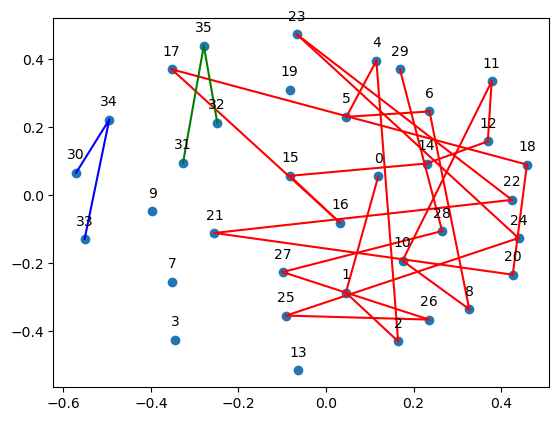

persistence =0.5592595788910835, finding: [31, 33]
 [[32, 33, 34, 35, 30, 31], [0, 1, 2, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]
merging
[[33, 34, 30], [32, 35, 31]]
[[1, 0], [2, 0]]
[0, 1, 2]
merging with pbow_d:  1.4142135623730951 12.806248474865697
pbow:
[array([3., 1., 0., 1., 0.]), array([4., 4., 8., 3., 5.])]
[[ 0.         10.14889157]
 [10.14889157  0.        ]]
score x0.5166666666666667: [1.0] [0.0] 
total score : 1.0

[[32, 33, 34, 35, 30, 31], [0, 1, 2, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]


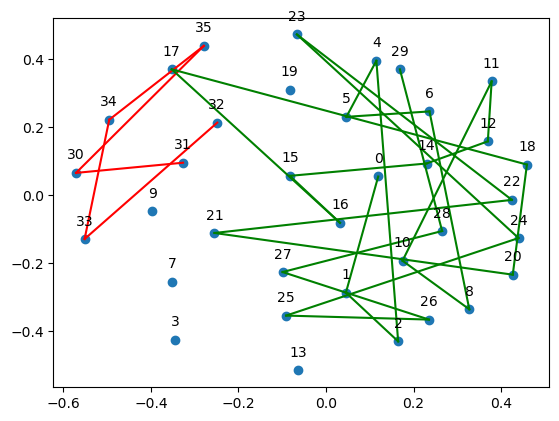

persistence =0.5609043612188882, finding: [9, 21]
 [[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]
merging
[[9]]
[[1, 0]]
pbow:
[array([4., 4., 4., 8., 5.]), array([1., 3., 1., 0., 0.])]
[[ 0.         10.39230485]
 [10.39230485  0.        ]]
score x0.5333333333333333: [0.0] [1.0] 
total score : 1.0

[[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]


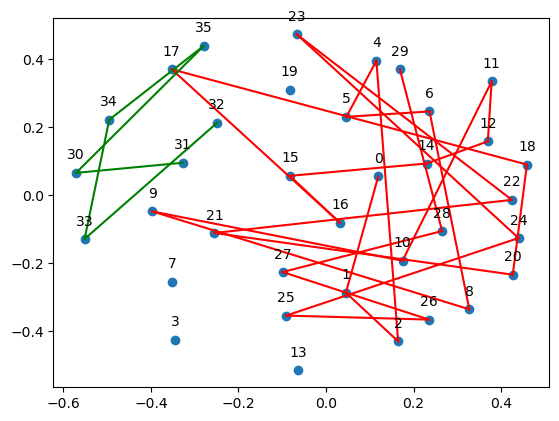

persistence =0.5709018118597528, finding: [16, 19]
 [[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]
merging
[[19]]
[[0, 0]]
pbow:
[array([2., 4., 7., 8., 5.]), array([1., 3., 1., 0., 0.])]
[[ 0.         11.26942767]
 [11.26942767  0.        ]]
score x0.55: [0.0] [1.0] 
total score : 1.0

[[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]


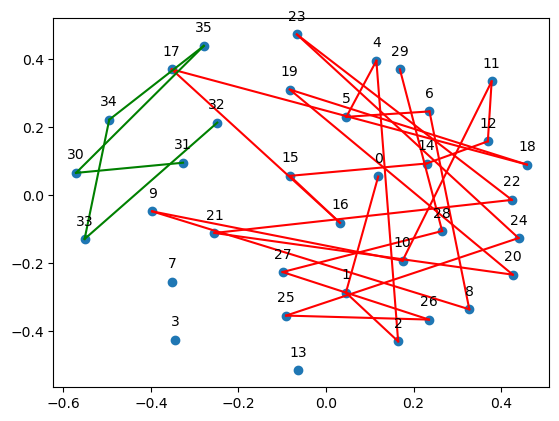

persistence =0.5802341508007558, finding: [13, 27]
 [[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]
merging
[[13]]
[[0, 0]]
pbow:
[array([4., 9., 8., 1., 5.]), array([1., 3., 0., 0., 1.])]
[[ 0.         11.22497216]
 [11.22497216  0.        ]]
score x0.5666666666666667: [0.0] [1.0] 
total score : 1.0

[[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]


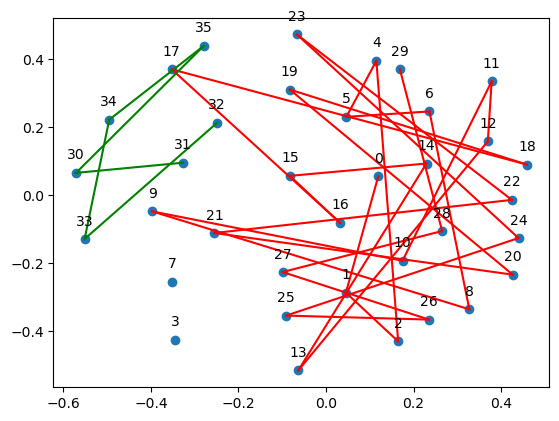

persistence =0.5847886629655716, finding: [25, 31]
 [[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[30, 31, 32, 33, 34, 35], [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  11.224972160321824 11.224972160321824
score x0.5666666666666667: [0.17647058823529413] 
total score : 0.8333333333333334

persistence =0.6085738491585336, finding: [7, 16]
 [[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[7]]
[[0, 0]]
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



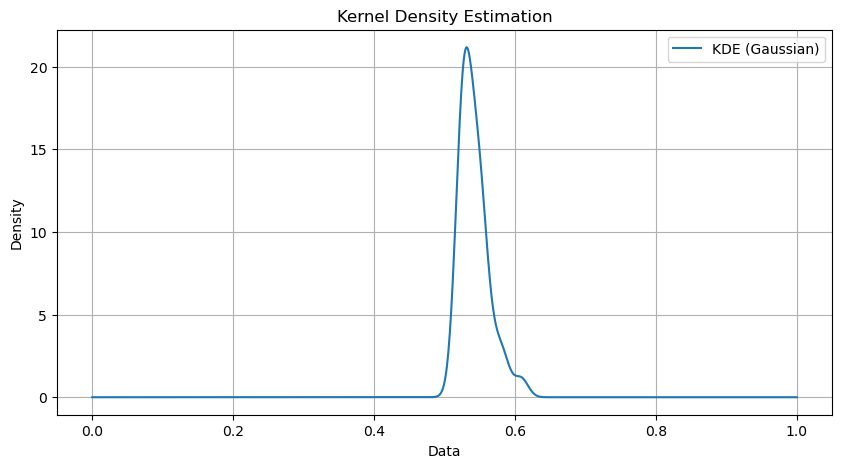

(36, 36)


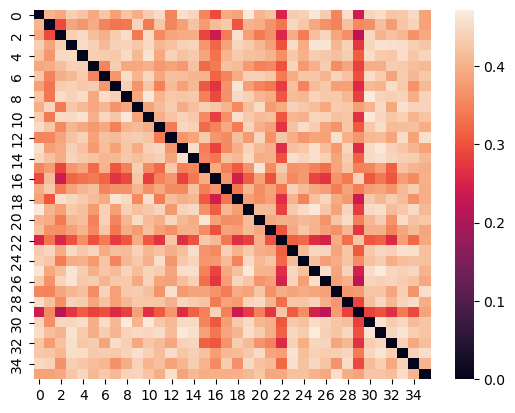

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


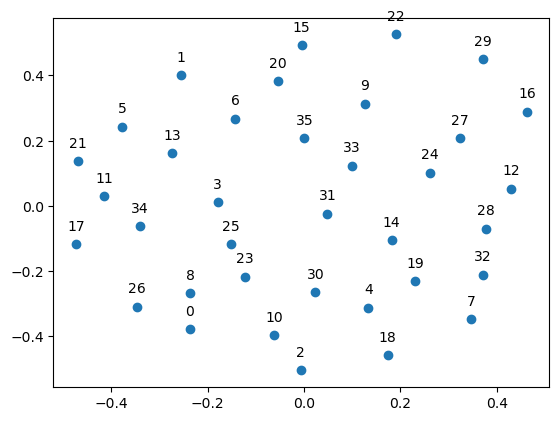

d 0 0 0.0 inf []
d 0 1 0.0 0.5744806753325774 [[9, 16]]
d 0 2 0.0 0.5725754137405714 [[6, 21]]
d 0 3 0.0 0.5690191950025765 [[15, 22]]
d 0 4 0.0 0.5627932956338482 [[17, 23]]
d 0 5 0.0 0.5591177254421473 [[16, 29]]
d 0 6 0.0 0.5573401888797543 [[5, 23]]
d 0 7 0.0 0.5534467765025811 [[1, 23]]
d 0 8 0.0 0.548584385428286 [[9, 20]]
d 0 9 0.0 0.5481024389803029 [[11, 31]]
d 0 10 0.0 0.5456389585247168 [[11, 24]]
d 0 11 0.0 0.5452630603536872 [[6, 8]]
d 0 12 0.0 0.5452217091078267 [[33, 35]]
d 0 13 0.0 0.5444930418225704 [[23, 34]]
d 0 14 0.0 0.5442219828604207 [[0, 28]]
d 0 15 0.0 0.5432371766055151 [[10, 18]]
d 0 16 0.0 0.542900589828452 [[12, 35]]
d 0 17 0.0 0.5426982612698787 [[12, 27]]
d 0 18 0.0 0.542650334141267 [[2, 18]]
d 0 19 0.0 0.5423231504288509 [[14, 31]]
d 0 20 0.0 0.5416878510295554 [[9, 33]]
d 0 21 0.0 0.5416042232934248 [[3, 32]]
d 0 22 0.0 0.5404214010012703 [[4, 10]]
d 0 23 0.0 0.5394810785079259 [[23, 33]]
d 0 24 0.0 0.5390245354698221 [[3, 26]]
d 0 25 0.0 0.53895449579

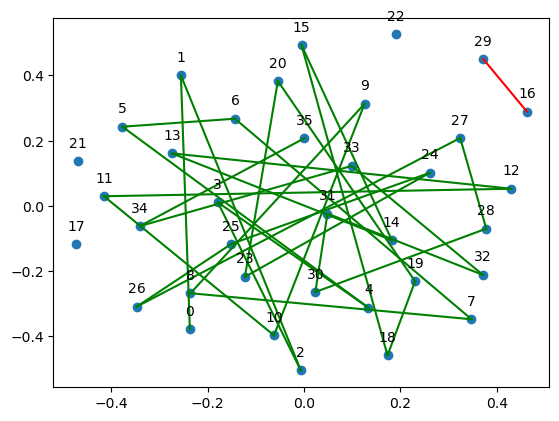

persistence =0.5690191950025765, finding: [17, 23]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35], [16, 29]]
merging
[[17]]
[[1, 0]]
pbow:
[array([ 5., 26.]), array([1., 0.])]
[[ 0.         26.30589288]
 [26.30589288  0.        ]]
score x0.5666666666666667: [0.1875] [0.0] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35], [16, 29]]


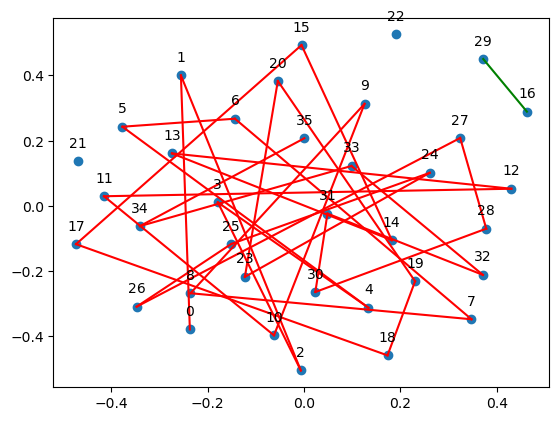

persistence =0.5725754137405714, finding: [15, 22]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35], [16, 29]]
merging
[[22]]
[[0, 0]]
pbow:
[array([28.,  4.]), array([0., 1.])]
[[ 0.         28.16025568]
 [28.16025568  0.        ]]
score x0.5833333333333334: [0.18181818181818182] [0.0] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35], [16, 29]]


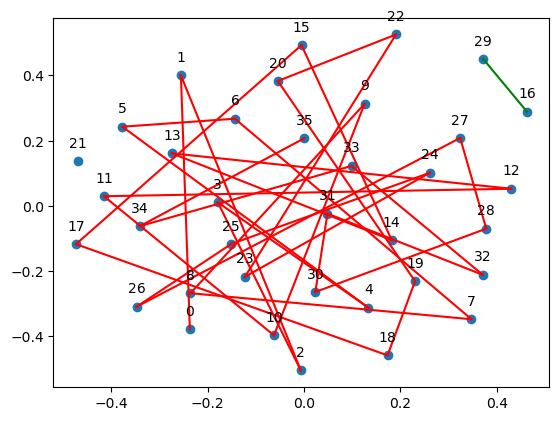

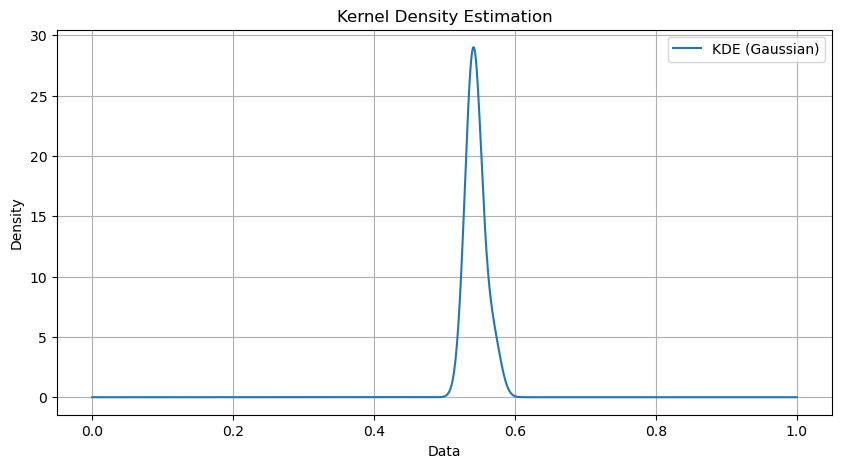

(36, 36)


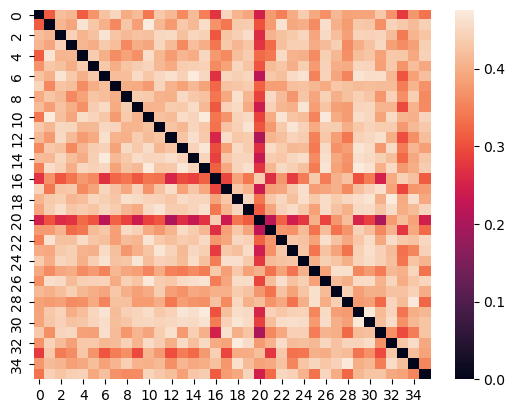

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


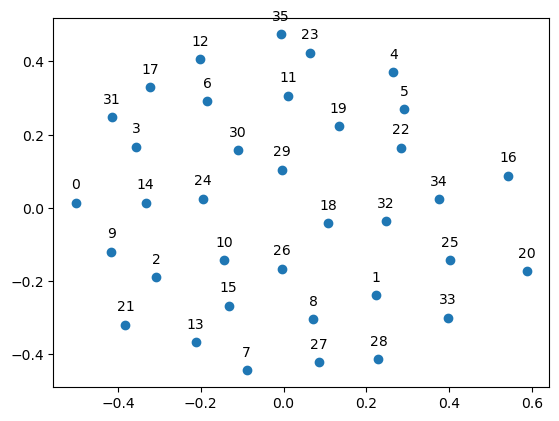

d 0 0 0.0 inf []
d 0 1 0.0 0.5662054659828085 [[16, 25]]
d 0 2 0.0 0.5641613383408877 [[16, 20]]
d 0 3 0.0 0.5590829971834711 [[16, 33]]
d 0 4 0.0 0.5524461368120074 [[7, 11]]
d 0 5 0.0 0.550628454983167 [[0, 7]]
d 0 6 0.0 0.5503425765695589 [[5, 29]]
d 0 7 0.0 0.5487421673791009 [[3, 31]]
d 0 8 0.0 0.5486622088016297 [[22, 35]]
d 0 9 0.0 0.5461280247728971 [[13, 21]]
d 0 10 0.0 0.5390302553610604 [[12, 31]]
d 0 11 0.0 0.5388145528770882 [[8, 18]]
d 0 12 0.0 0.5387285058394513 [[17, 31]]
d 0 13 0.0 0.538273315515742 [[15, 19]]
d 0 14 0.0 0.5379120469697338 [[25, 28]]
d 0 15 0.0 0.5377438025980958 [[25, 27]]
d 0 16 0.0 0.5377029553322575 [[6, 12]]
d 0 17 0.0 0.5373646856001966 [[18, 34]]
d 0 18 0.0 0.5365683956868273 [[6, 24]]
d 0 19 0.0 0.5352577870786318 [[10, 22]]
d 0 20 0.0 0.534967927890029 [[1, 4]]
d 0 21 0.0 0.5348291571676063 [[2, 6]]
d 0 22 0.0 0.5347934287956526 [[11, 19]]
d 0 23 0.0 0.5347922560563036 [[6, 29]]
d 0 24 0.0 0.5333411610081821 [[9, 24]]
d 0 25 0.0 0.533021724504

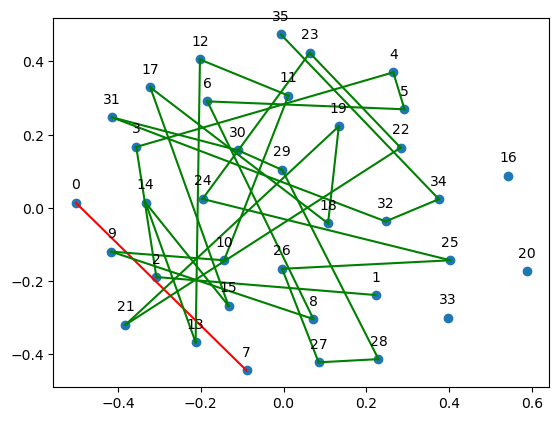

persistence =0.5590829971834711, finding: [7, 11]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35]]
merging
[[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35], [0, 7]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  26.1725046566048 26.1725046566048
score x0.55: [0.15151515151515152] 
total score : 0.8611111111111112

persistence =0.5641613383408877, finding: [16, 33]
 [[16, 33], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35]]
merging
[]
[]
pbow:
[array([0., 1.]), array([26.,  6.])]
[[ 0.         26.47640459]
 [26.47640459  0.        ]]
score x0.5833333333333334: [0.5] [0.15151515151515152] 
total score : 0.8333333333333334

[[16, 33], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35]]


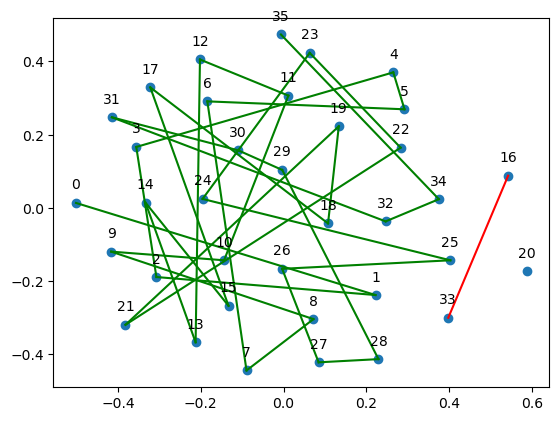

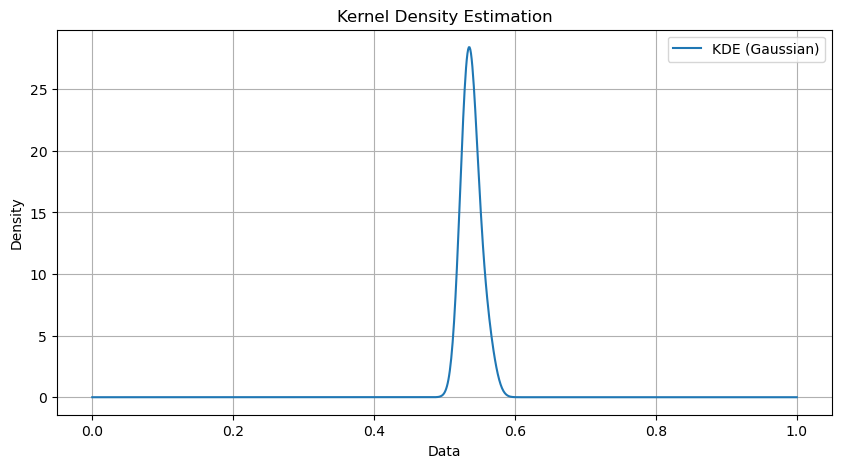

(36, 36)


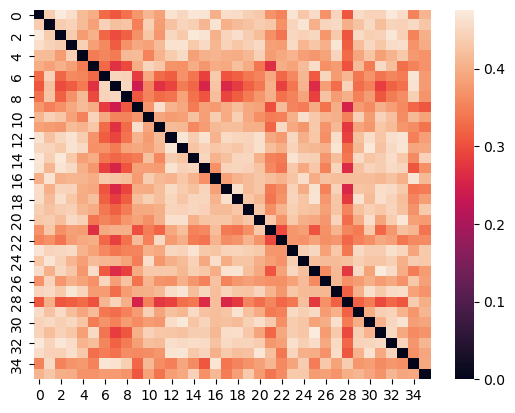

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


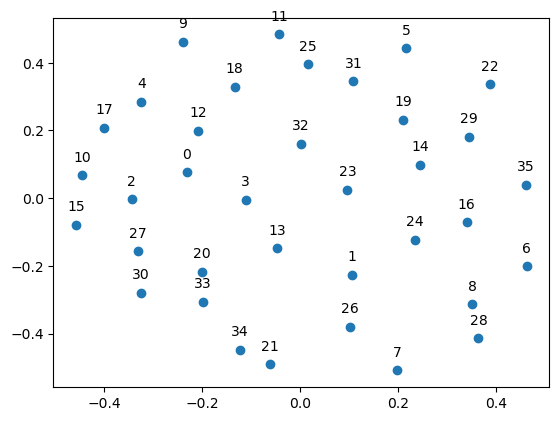

d 0 0 0.0 inf []
d 0 1 0.0 0.5683672877345087 [[11, 25]]
d 0 2 0.0 0.5660824812829314 [[21, 30]]
d 0 3 0.0 0.5567850921495753 [[14, 35]]
d 0 4 0.0 0.5545752457146174 [[7, 28]]
d 0 5 0.0 0.5507404263799379 [[6, 26]]
d 0 6 0.0 0.5499544540106294 [[14, 19]]
d 0 7 0.0 0.5489701843921109 [[7, 8]]
d 0 8 0.0 0.5483290345445084 [[11, 22], [1, 27, 30]]
d 0 9 0.0 0.5472635774648994 [[1, 30]]
d 0 10 0.0 0.5470265218691179 [[4, 13]]
d 0 11 0.0 0.542689284229437 [[5, 25]]
d 0 12 0.0 0.5400045838066762 [[10, 24]]
d 0 13 0.0 0.5397956649969382 [[2, 18]]
d 0 14 0.0 0.5394344570781429 [[9, 11]]
d 0 15 0.0 0.5370912969186993 [[18, 29]]
d 0 16 0.0 0.5369669708840819 [[17, 25]]
d 0 17 0.0 0.5361568098815517 [[7, 34]]
d 0 18 0.0 0.5356165610921731 [[12, 15]]
d 0 19 0.0 0.5350513287580344 [[2, 15]]
d 0 20 0.0 0.5344902472943464 [[0, 23]]
d 0 21 0.0 0.5343976336126446 [[18, 25]]
d 0 22 0.0 0.5336729573060006 [[1, 16]]
d 0 23 0.0 0.5331411100691558 [[1, 24]]
d 0 24 0.0 0.5331265584055123 [[13, 27]]
d 0 25 0.0

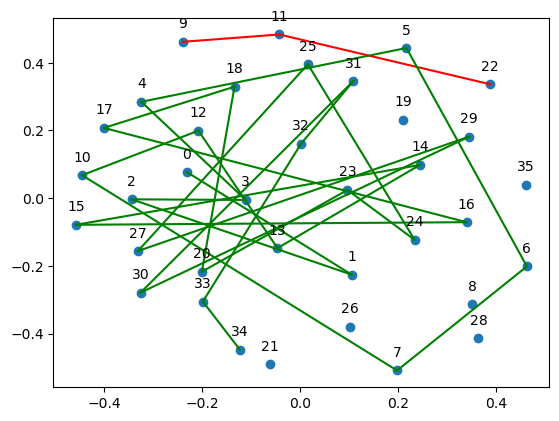

persistence =0.5499544540106294, finding: [7, 8]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34], [9, 11, 22]]
merging
[[8]]
[[1, 0]]
pbow:
[array([17.,  6.,  4.]), array([1., 0., 1.])]
[[ 0.         17.34935157]
 [17.34935157  0.        ]]
score x0.5166666666666667: [0.17857142857142858] [0.0] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34], [9, 11, 22]]


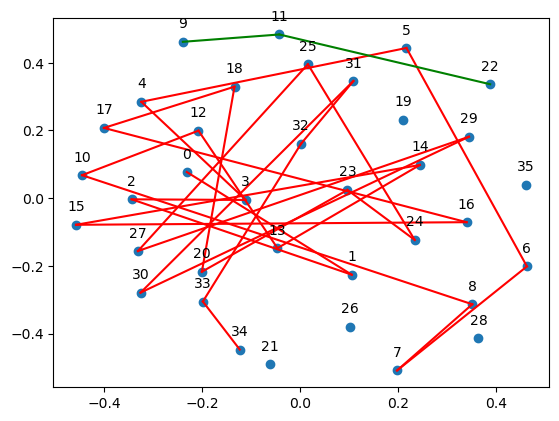

persistence =0.5507404263799379, finding: [14, 19]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34], [9, 11, 22]]
merging
[[19]]
[[0, 0]]
pbow:
[array([ 6.,  5., 17.]), array([0., 1., 1.])]
[[ 0.         17.54992877]
 [17.54992877  0.        ]]
score x0.5333333333333333: [0.1724137931034483] [0.0] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34], [9, 11, 22]]


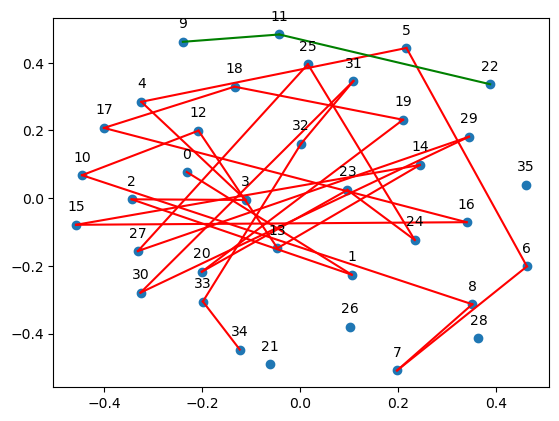

persistence =0.5545752457146174, finding: [6, 26]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34], [9, 11, 22]]
merging
[[26]]
[[0, 0]]
pbow:
[array([ 6., 17.,  6.]), array([0., 1., 1.])]
[[ 0.         17.80449381]
 [17.80449381  0.        ]]
score x0.55: [0.16666666666666666] [0.0] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34], [9, 11, 22]]


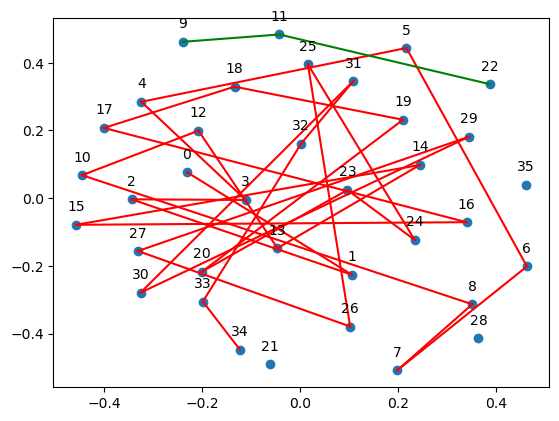

persistence =0.5567850921495753, finding: [7, 28]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], [9, 11, 22]]
merging
[[28]]
[[0, 0]]
pbow:
[array([ 6., 17.,  7.]), array([0., 1., 1.])]
[[ 0.         18.11077028]
 [18.11077028  0.        ]]
score x0.5666666666666667: [0.16129032258064516] [0.0] 
total score : 0.8611111111111112

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], [9, 11, 22]]


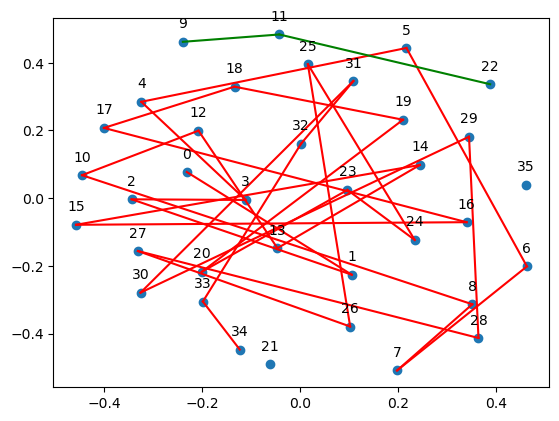

persistence =0.5660824812829314, finding: [14, 35]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [9, 11, 22]]
merging
[[35]]
[[0, 0]]
pbow:
[array([18.,  8.,  5.]), array([1., 1., 0.])]
[[ 0.         19.05255888]
 [19.05255888  0.        ]]
score x0.5833333333333334: [0.1875] [0.0] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], [9, 11, 22]]


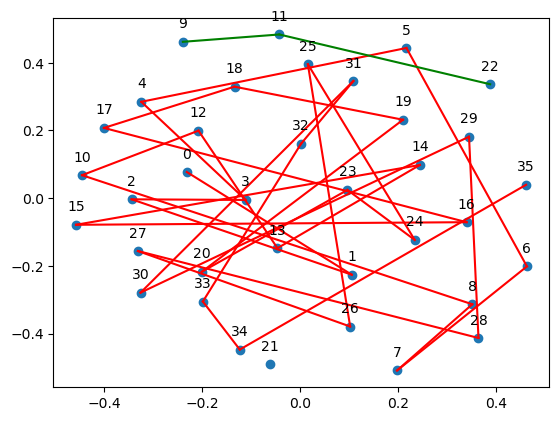

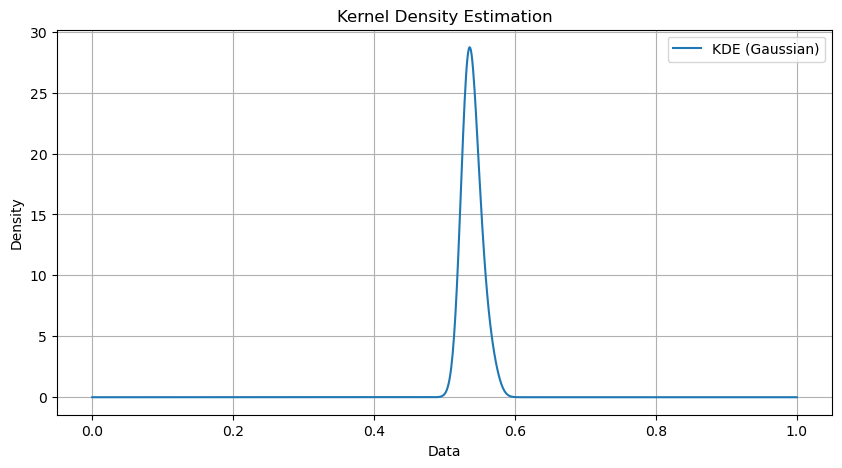

(36, 36)


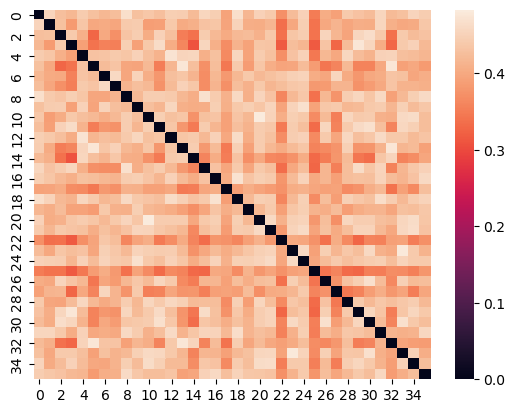

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


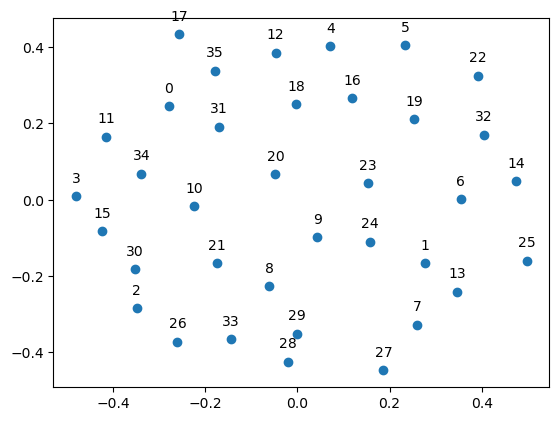

d 0 0 0.0 inf []
d 0 1 0.0 0.5877850465721941 [[19, 25]]
d 0 2 0.0 0.5718633675968738 [[17, 35]]
d 0 3 0.0 0.5623744279918308 [[6, 22]]
d 0 4 0.0 0.5536935704970022 [[9, 19]]
d 0 5 0.0 0.5486920025140907 [[33, 6, 20, 21, 24]]
d 0 6 0.0 0.5465535070235228 [[4, 13]]
d 0 7 0.0 0.5452222875574042 [[6, 27]]
d 0 8 0.0 0.5439470967624388 [[4, 14]]
d 0 9 0.0 0.5437965692047394 [[1, 31]]
d 0 10 0.0 0.5428894800183136 [[4, 28]]
d 0 11 0.0 0.5397469813463361 [[10, 33]]
d 0 12 0.0 0.5396078597346807 [[6, 7]]
d 0 13 0.0 0.5387483139979079 [[8, 35]]
d 0 14 0.0 0.5380633979791681 [[21, 24]]
d 0 15 0.0 0.5375797018205776 [[12, 18]]
d 0 16 0.0 0.5370633562005117 [[3, 11]]
d 0 17 0.0 0.5362523791625831 [[15, 29]]
d 0 18 0.0 0.5361695497595914 [[20, 34]]
d 0 19 0.0 0.5347357812159466 [[2, 30]]
d 0 20 0.0 0.5344704707884733 [[18, 31]]
d 0 21 0.0 0.5342022066191415 [[21, 34]]
d 0 22 0.0 0.5334437699231975 [[0, 18]]
d 0 23 0.0 0.5333722047979279 [[0, 8]]
d 0 24 0.0 0.5317490843743045 [[30, 33]]
d 0 25 0.0 0

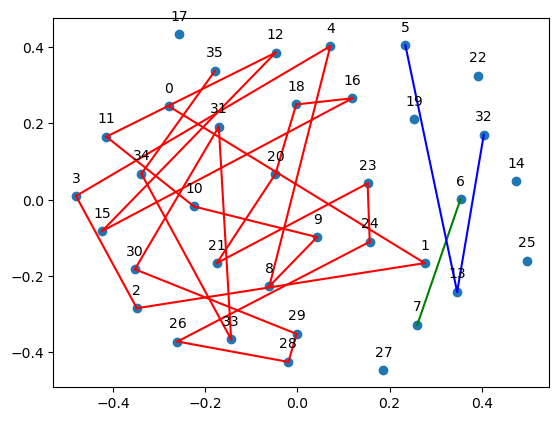

persistence =0.5452222875574042, finding: [4, 14]
 [[0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 23, 24, 26, 28, 29, 30, 31, 33, 34, 35], [6, 7], [32, 13, 5]]
merging
[[14]]
[[0, 0]]
pbow:
[array([ 5., 20.]), array([0., 1.]), array([2., 0.])]
[[ 0.         19.6468827  20.22374842]
 [19.6468827   0.          2.23606798]
 [20.22374842  2.23606798  0.        ]]
score x0.5166666666666667: [0.19230769230769232] [0.0] [0.3333333333333333] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 23, 24, 26, 28, 29, 30, 31, 33, 34, 35], [6, 7], [32, 13, 5]]


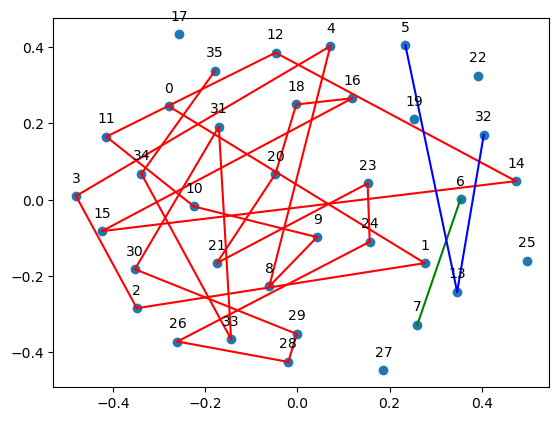

persistence =0.5465535070235228, finding: [6, 27]
 [[27, 6, 7], [0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 23, 24, 26, 28, 29, 30, 31, 33, 34, 35], [32, 13, 5]]
merging
[[27]]
[[1, 0]]
pbow:
[array([2., 0., 0.]), array([10., 12.,  3.]), array([0., 0., 2.])]
[[ 0.         14.73091986  2.82842712]
 [14.73091986  0.         15.65247584]
 [ 2.82842712 15.65247584  0.        ]]
score x0.5333333333333333: [0.0] [0.19230769230769232] [0.3333333333333333] 
total score : 0.8333333333333334

[[27, 6, 7], [0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 23, 24, 26, 28, 29, 30, 31, 33, 34, 35], [32, 13, 5]]


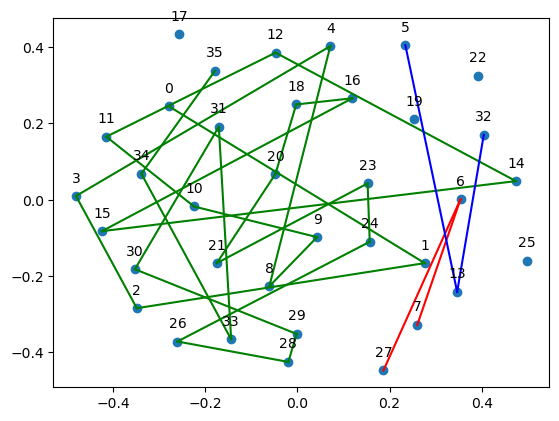

persistence =0.5486920025140907, finding: [4, 13]
 [[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35], [27, 6, 7]]
merging
[[5, 13, 32], [0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 23, 24, 26, 28, 29, 30, 31, 33, 34, 35]]
[[1, 0], [2, 0]]
[0, 1, 2]
merging with pbow_d:  15.652475842498529 15.652475842498529
pbow:
[array([ 9.,  5., 14.]), array([2., 0., 0.])]
[[ 0.         16.43167673]
 [16.43167673  0.        ]]
score x0.5333333333333333: [0.20689655172413793] [0.0] 
total score : 0.8333333333333334

[[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35], [27, 6, 7]]


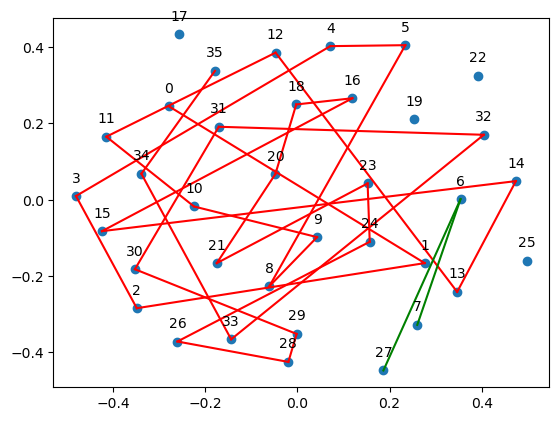

persistence =0.5536935704970022, finding: [33, 6, 20, 21, 24]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[6, 7, 27], [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  16.431676725154983 16.431676725154983
score x0.5333333333333333: [0.1875] 
total score : 0.8333333333333334

persistence =0.5623744279918308, finding: [9, 19]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[19]]
[[0, 0]]
score x0.55: [0.18181818181818182] 
total score : 0.8333333333333334

persistence =0.5718633675968738, finding: [6, 22]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[22]]
[[0, 0]]
score x0.5666666666666667: [0.17647058823529413] 
total 

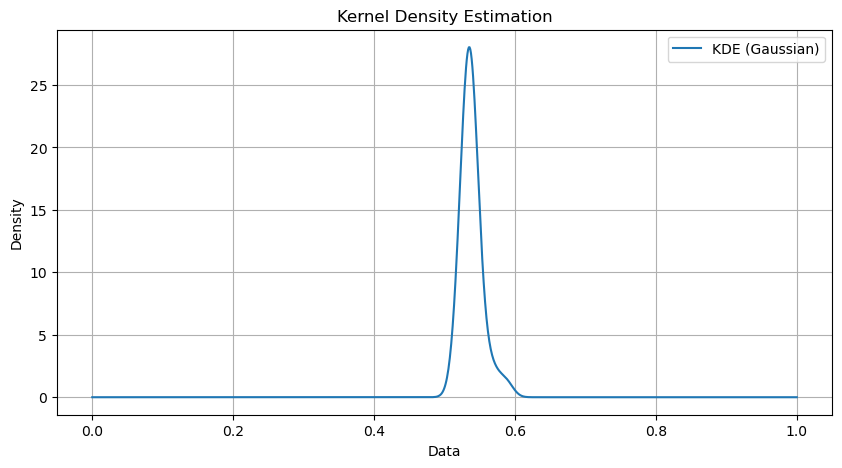

(36, 36)


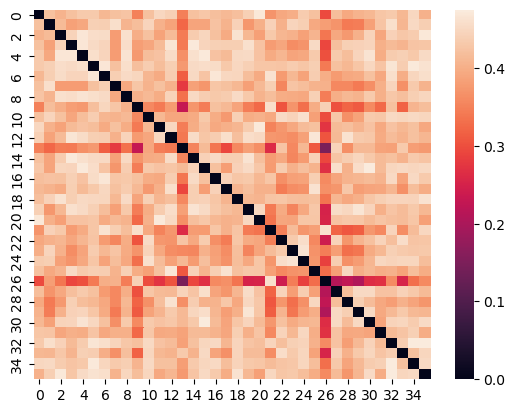

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


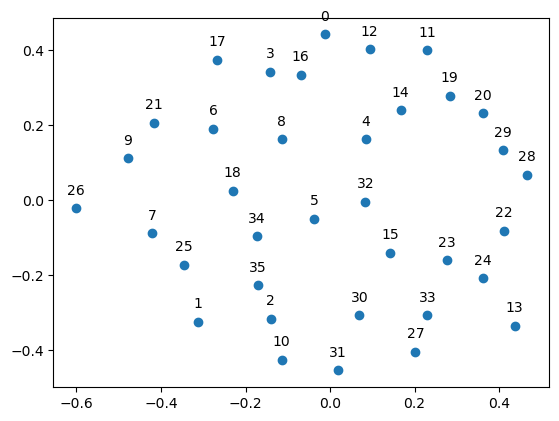

d 0 0 0.0 inf []
d 0 1 0.0 0.5561434976878287 [[13, 27]]
d 0 2 0.0 0.5501274550242374 [[24, 31]]
d 0 3 0.0 0.5479141793128817 [[12, 20]]
d 0 4 0.0 0.5476977546182564 [[15, 33]]
d 0 5 0.0 0.5426131850168632 [[22, 24]]
d 0 6 0.0 0.5419355559025312 [[22, 33]]
d 0 7 0.0 0.5413973638996393 [[15, 27]]
d 0 8 0.0 0.5399201750772744 [[9, 21]]
d 0 9 0.0 0.5398712479029036 [[1, 32]]
d 0 10 0.0 0.5397310622176531 [[1, 7]]
d 0 11 0.0 0.5392577851933305 [[21, 26]]
d 0 12 0.0 0.5379049533122393 [[10, 24]]
d 0 13 0.0 0.5372988136565777 [[12, 28]]
d 0 14 0.0 0.5372642744875267 [[17, 25]]
d 0 15 0.0 0.5367912827103477 [[18, 35]]
d 0 16 0.0 0.5367533385443976 [[6, 21]]
d 0 17 0.0 0.5355536565433457 [[14, 19]]
d 0 18 0.0 0.5352095040409822 [[4, 8]]
d 0 19 0.0 0.5344244298544327 [[23, 24]]
d 0 20 0.0 0.5339435920493203 [[3, 12]]
d 0 21 0.0 0.5325803861497127 [[19, 29]]
d 0 22 0.0 0.5317140146087519 [[12, 25]]
d 0 23 0.0 0.5315206834390438 [[2, 4]]
d 0 24 0.0 0.5311288843767941 [[6, 16]]
d 0 25 0.0 0.530706

IndexError: list index out of range

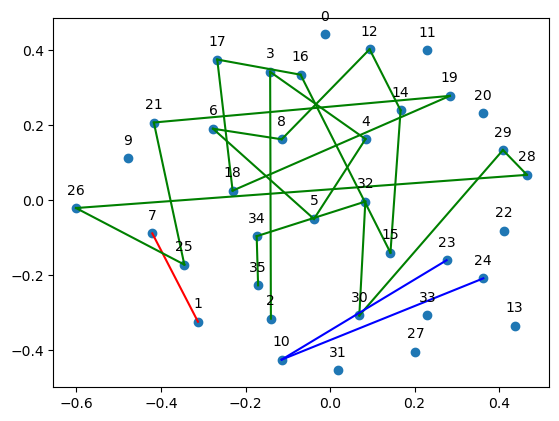

In [16]:
%matplotlib inline
for corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    sns.heatmap(1-data)
    plt.show()

    # Apply Multidimensional Scaling
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    mds_results = mds.fit_transform(data)

    # Plot the points
    plt.scatter(mds_results[:, 0], mds_results[:, 1])

    for i, points in enumerate(mds_results):
        plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()

    rips_complex = gd.RipsComplex(distance_matrix=data, max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()

    
    count = 0
    results = []
    dv_seq = []

    for (birth_value, death_value), d in [(i[1], i[0]) for i in persistence if i[0] == 0]:
        tolerance = 1e-6
        birth_simplices = []
        death_simplices = []
        filtration = simplex_tree.get_filtration()

        for simplex, filtration_value in filtration:
            # print(filtration_value, birth_value)
            if abs(filtration_value - birth_value) < tolerance:
                # print(simplex)
                birth_simplices.append(simplex)
            elif abs(filtration_value - death_value) < tolerance or (death_value == np.Inf and d != 0):
                death_simplices.append(simplex)
                
        involved_points_d = (merge_sublists_with_shared_items(death_simplices))

        if len(involved_points_d) >= 0 : 
            print('d', d, count, birth_value, death_value, involved_points_d) 
            results.append([death_value, involved_points_d])
            dv_seq.append(death_value)
        count += 1
    print("the gaps:")
    print(find_largest_gaps(dv_seq, 3))
    
    a = []
    for [death_value, concern_points] in results:
        for c in concern_points:
            # print(c)
            a.append(c)
            
    print(a)
    last_merged = None
    last_distance = None
    score = 0
    has_draw = False
    for i in range(min(len(a)-1, len(results)-1), -1, -1):
        warn_flag = False
        f = flatten(a[i:len(a)])
        if (np.unique(f).shape[0] == total_nums):
            continue
        merged = merge_sublists_with_shared_items(a[i:len(a)])
        print(f"persistence ={results[i][0]}, finding: {a[i]}\n", merged)
        # print(merged, last_merged)
        score = get_total_length(merged)/normal_nums/2

        newly_merged = []
        newly_added = []
        merging = []

        if (last_merged != None and len(last_merged)):
            print("merging")
            for idxa, list_a in enumerate(last_merged):
                for idxb, list_b in enumerate(merged):
                    # print(list_a, list_b)
                    if (is_proper_superset(list_a, list_b)):
                        newly_merged.append([idxa, idxb])
                        newly_added.append(find_different_elements(list_a, list_b))
        
            print(newly_added)
            print(newly_merged)

            if (len(newly_merged) >= 2):
                merging = list(set(newly_merged[0] + newly_merged[1]))
                # merging = find_different_elements(newly_merged[0], newly_merged[1])
                print(merging)
                # print(last_distance)
                if(len(merging) and last_distance.shape[0] > max(merging[-1], merging[-2])):
                    print("merging with pbow_d: ",last_distance[merging[-1]][merging[-2]], np.max(last_distance))
                    if (last_distance[merging[-1]][merging[-2]] >= np.max(last_distance)/2 and score > 0.6 ):
                        print("warn")
                        warn_flag = True
                        a[i] = [0, 0]
                        merged = copy.deepcopy(last_merged)

        
        last_merged = copy.deepcopy(merged)


        
        sub_pers = []
        min_length = float('Inf')
        for sub_points in merged:
            if (len(sub_points) <= 1):
                continue
            min_length = min(min_length, len(sub_points))
            sub_diagram = gd.RipsComplex(distance_matrix=np.array(data)[sub_points][:,sub_points], max_edge_length=100)
            sub_simplex_tree = sub_diagram.create_simplex_tree(max_dimension=2)
            sub_persistence = sub_simplex_tree.persistence()
            sub_pd = np.array([[b, d] for dim, (b, d) in sub_persistence if (dim == 0) and (d != float('inf'))])
            sub_pers.append(sub_pd)

        if (len(sub_pers) > 1 and min_length > 1):
            pbow = perscode.PBoW(N = min(5, min_length), normalize = False)
            pbow_diagrams  = pbow.transform(sub_pers)
            print("pbow:")
            print(pbow_diagrams)
            pbow_distance = np.zeros((len(pbow_diagrams),len(pbow_diagrams)))
            for k in range(len(pbow_diagrams)):
                for j in range(len(pbow_diagrams)):
                    pbow_distance[k][j] = np.linalg.norm(pbow_diagrams[k] - pbow_diagrams[j])
            print(pbow_distance)
        
            if (not warn_flag):
                last_distance = copy.deepcopy(pbow_distance)

        print(f"score x{score}: ",end='')
        total_errors = 0
        for j in merged:
            print([np.mean(np.array(j) >= normal_nums)], end=' ')
            total_errors += min(np.sum((np.array(j) >= normal_nums) == 0),np.sum((np.array(j) >= normal_nums) == 1))
        print(f"\ntotal score : {1- total_errors/data.shape[0]}")
        print()

        if (score >= 0.5 and len(merged) > 1):
            plt.clf()
            plt.scatter(mds_results[:, 0], mds_results[:, 1])
            for idx, points in enumerate(mds_results):
                plt.annotate(idx, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')

            # print(merged)
            draw_point_set = copy.deepcopy(merged)
            colors = ['r', 'g', 'b']
            for color, layer in enumerate(merged):
                # print(layer)
                for p in range(len(layer)-1):
                    p1 = mds_results[layer[p]]
                    p2 = mds_results[layer[p + 1]]
                    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], colors[color]+'-')
            has_draw = True
            print(draw_point_set)
            plt.show()

    if (has_draw):
        pass

    group = np.zeros((total_nums,total_nums))
    for i in merge_sublists_with_shared_items(a)[0]:
        group[i][i] = 1

    
    X = np.array([x for x in dv_seq if x != float('Inf')])
    X = X.reshape(-1, 1)

    # 初始化KDE模型
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)

    # 进行密度估计
    X_sample = np.linspace(0, 1, 1000).reshape(-1, 1)
    log_dens = kde.score_samples(X_sample)

    plt.figure(figsize=(10, 5))
    plt.plot(X_sample, np.exp(log_dens), label='KDE (Gaussian)')
    plt.title('Kernel Density Estimation')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plt.scatter(mds_results[:, 0], mds_results[:, 1])
    # for i, points in enumerate(mds_results):
    #     plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    # plt.show()


In [ ]:


# 生成样本数据
X = np.array([x for x in dv_seq if x != float('Inf')])
X = X.reshape(-1, 1)

# 初始化KDE模型
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)

# 进行密度估计
X_sample = np.linspace(-0.5, 0.5, 1000).reshape(-1, 1)
log_dens = kde.score_samples(X_sample)


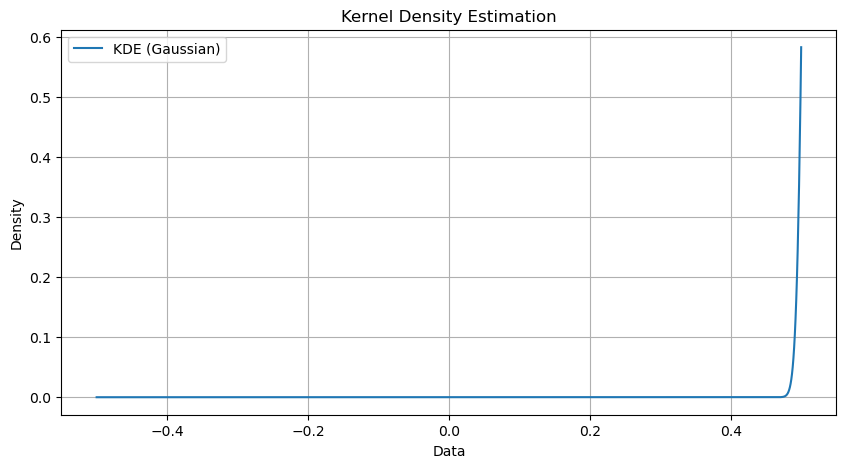

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(X_sample, np.exp(log_dens), label='KDE (Gaussian)')
plt.title('Kernel Density Estimation')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
%matplotlib inline
for corr in corr_set:
    data = 1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T
    Z = linkage(data, 'ward')
    # Z = linkage(scipy.spatial.distance.squareform(corr.reshape(-1,99) + corr.reshape(-1,99).T), 'ward')
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(Z)
    plt.show()
    num_clusters = 2
    clusters = np.array(fcluster(Z, num_clusters, criterion='maxclust'))
    print(clusters)
    print(1 - abs(np.mean(clusters-1) - 0.5))
    cluster_matrices = {}

    # 根据聚类结果，将距离矩阵划分为num_clusters个子矩阵
    for cluster_id in range(1, num_clusters + 1):
        # 获取属于当前聚类簇的数据点索引
        cluster_indices = np.where(clusters == cluster_id)[0]
        
        # 根据索引获取子矩阵
        sub_matrix = data[cluster_indices][:, cluster_indices]
        
        # 将子矩阵添加到字典中
        cluster_matrices[cluster_id] = sub_matrix

    %matplotlib inline
    for idx in range(1, len(cluster_matrices)+1):
        # data = 1 - corr.reshape(-1, 2 * client_max) - corr.reshape(-1, 2 * client_max).T
        data = cluster_matrices[idx]
        print(data.shape)
        # df=pd.DataFrame(data)
        # plot=seaborn.heatmap(df)
        # plt.show()
        sns.heatmap(1-data)
        plt.show()

        # Apply Multidimensional Scaling
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
        mds_results = mds.fit_transform(data)

        # Plot the points
        plt.scatter(mds_results[:, 0], mds_results[:, 1])

        for i, points in enumerate(mds_results):
            plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
        plt.show()

        rips_complex = gd.RipsComplex(distance_matrix=data, max_edge_length=100)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        persistence = simplex_tree.persistence()

        
        count = 0
        results = []

        for (birth_value, death_value), d in [(i[1], i[0]) for i in persistence if i[0] == 0]:
            tolerance = 1e-6
            birth_simplices = []
            death_simplices = []
            filtration = simplex_tree.get_filtration()

            for simplex, filtration_value in filtration:
                # print(filtration_value, birth_value)
                if abs(filtration_value - birth_value) < tolerance:
                    # print(simplex)
                    birth_simplices.append(simplex)
                elif abs(filtration_value - death_value) < tolerance or (death_value == np.Inf and d != 0):
                    death_simplices.append(simplex)
                    
            involved_points_d = (merge_sublists_with_shared_items(death_simplices))

            if len(involved_points_d) >= 0 : 
                print('d', d, count, birth_value, death_value, involved_points_d) 
                results.append([death_value, involved_points_d])
            count += 1
        
        prefixSum = np.zeros(len(results)-2)
        prefixSum[0] = results[2][0]
        for i in range (3, len(prefixSum)-1):
            prefixSum[i-2] = (prefixSum[i-3]+results[i][0])
        
        partitionIdx = 0
        maxDifference = 0.0
        for i in range (0, len(prefixSum)):
            avg1 = prefixSum[i] / (i + 1)
            avg2 = (prefixSum[len(prefixSum)-1] - prefixSum[i]) / (len(prefixSum) - i - 1)
            difference = abs(avg1 - avg2)

            if (difference > maxDifference):
                partitionIdx = i
                maxDifference = difference

        print(f"Break point is {partitionIdx}")


        a = []
        for [death_value, concern_points] in results:
            for c in concern_points:
                # print(c)
                a.append(c)
                
        print(a)
        last_merged = None
        last_distance = None
        score = 0
        for i in range(min(len(a)-1, len(results)-1), -1, -1):
            warn_flag = False
            f = flatten(a[i:len(a)])
            if (np.unique(f).shape[0] == client_max*2):
                continue
            merged = merge_sublists_with_shared_items(a[i:len(a)])
            print(f"persistence ={results[i][0]}, finding: {a[i]}\n", merged)
            # print(merged, last_merged)
            score = get_total_length(merged)/client_max/2

            newly_merged = []
            newly_added = []
            merging = []

            if (last_merged != None and len(last_merged)):
                print("merging")
                for idxa, list_a in enumerate(last_merged):
                    for idxb, list_b in enumerate(merged):
                        # print(list_a, list_b)
                        if (is_proper_superset(list_a, list_b)):
                            newly_merged.append([idxa, idxb])
                            newly_added.append(find_different_elements(list_a, list_b))
            
                print(newly_added)
                print(newly_merged)

                if (len(newly_merged) >= 2):
                    merging = list(set(newly_merged[0] + newly_merged[1]))
                    # merging = find_different_elements(newly_merged[0], newly_merged[1])
                    print(merging)
                    # print(last_distance)
                    if(len(merging) and last_distance.shape[0] > max(merging[-1], merging[-2])):
                        print("merging with pbow_d: ",last_distance[merging[-1]][merging[-2]], np.max(last_distance))
                        if (last_distance[merging[-1]][merging[-2]] >= np.max(last_distance)/2 and score > 0.6 ):
                            print("warn")
                            warn_flag = True
                            a[i] = [0, 0]
                            merged = copy.deepcopy(last_merged)

            
            last_merged = copy.deepcopy(merged)


            
            sub_pers = []
            min_length = float('Inf')
            for sub_points in merged:
                if (len(sub_points) <= 1):
                    continue
                min_length = min(min_length, len(sub_points))
                sub_diagram = gd.RipsComplex(distance_matrix=np.array(data)[sub_points][:,sub_points], max_edge_length=100)
                sub_simplex_tree = sub_diagram.create_simplex_tree(max_dimension=2)
                sub_persistence = sub_simplex_tree.persistence()
                sub_pd = np.array([[b, d] for dim, (b, d) in sub_persistence if (dim == 0) and (d != float('inf'))])
                sub_pers.append(sub_pd)

            if (len(sub_pers) > 1 and min_length > 1):
                pbow = perscode.PBoW(N = min(5, min_length), normalize = False)
                pbow_diagrams  = pbow.transform(sub_pers)
                print("pbow:")
                print(pbow_diagrams)
                pbow_distance = np.zeros((len(pbow_diagrams),len(pbow_diagrams)))
                for i in range(len(pbow_diagrams)):
                    for j in range(len(pbow_diagrams)):
                        pbow_distance[i][j] = np.linalg.norm(pbow_diagrams[i] - pbow_diagrams[j])
                print(pbow_distance)
            
                if (not warn_flag):
                    last_distance = copy.deepcopy(pbow_distance)

            print(f"score x{score}: ",end='')
            for j in merged:
                print([np.mean(np.array(j) >= client_max)], end=' ')
            print()


        group = np.zeros((client_max*2,client_max*2))
        for i in merge_sublists_with_shared_items(a)[0]:
            group[i][i] = 1


        

ValueError: cannot reshape array of size 1296 into shape (60)